In [1]:
from Helper.ml_models import * 
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks
import numpy as np
import pandas as pd
from tqdm import tqdm


index = 0


2025-01-21 15:56:35.077887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-21 15:56:35.625758: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = TrainedModel('deeplabv3_resnet50',
                     2048,
                     1024,
                     'deeplabv3_resnet50_k_fold_4',
                     folder_path='K_Fold_Run',
                     start_epoch='latest')

k_fold_dataset = K_Fold_Dataset(image_dir='CityscapesDaten/images',
                                            annotation_dir='CityscapesDaten/semantic',
                                            k_fold_csv_dir='Daten/CityscapesDaten',
                                            leave_out_fold=0)

k_fold_dataset.check_for_data_leaks()  

Using CUDA GPU
Model loaded: deeplabv3_resnet50 | Device: cuda 
No data leaks found.


In [3]:
image, annotation = k_fold_dataset.train_dataset[index]

print(f'Image shape: {image.shape}, Annotation shape: {annotation.shape}')
print(f'Annotation Value range: {np.unique(annotation)}')

Image shape: torch.Size([3, 520, 520]), Annotation shape: torch.Size([520, 520])
Annotation Value range: [ 0  1  2  4  5  8  9 10 11 13 19]


In [4]:
model.prepare_model_training(
    dataset_train=k_fold_dataset.train_dataset,
    dataset_val=k_fold_dataset.val_dataset,
    dataset_test=k_fold_dataset.test_dataset,
    batch_size=2, 
    shuffle=True,
    learning_rate=1e-5,
    num_workers=4,
    pin_memory=True
)

Training Dataset prepared
Validation Dataset prepared
Test Dataset prepared


In [5]:
# ACCURACY Metric 1

def compute_confusion_matrix(predicted, ground_truth, num_classes):
    mask = (ground_truth >= 0) & (ground_truth < num_classes)
    label = num_classes * ground_truth[mask] + predicted[mask]
    count = torch.bincount(label, minlength=num_classes**2)
    confusion_matrix = count.reshape(num_classes, num_classes)
    return confusion_matrix

def compute_miou(confusion_matrix):
    intersection = torch.diag(confusion_matrix)
    ground_truth_set = confusion_matrix.sum(1)
    predicted_set = confusion_matrix.sum(0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / (union + 1e-6)  # Kleine Konstante, um Division durch Null zu vermeiden
    mIoU = torch.mean(IoU)
    return mIoU.item(), IoU

def compute_mean_pixel_accuracy(confusion_matrix):
    true_positive = torch.diag(confusion_matrix)
    total_pixels = confusion_matrix.sum(1)
    pixel_accuracy = true_positive / (total_pixels + 1e-6)
    mPA = torch.mean(pixel_accuracy)
    return mPA.item(), pixel_accuracy

def compute_fwiou(confusion_matrix):
    total_pixels = confusion_matrix.sum()
    ground_truth_set = confusion_matrix.sum(1)
    intersection = torch.diag(confusion_matrix)
    union = ground_truth_set + confusion_matrix.sum(0) - intersection
    IoU = intersection / (union + 1e-6)
    FWIoU = (ground_truth_set * IoU) / total_pixels
    FWIoU = FWIoU.sum()
    return FWIoU.item()

def compute_dice_coefficient(confusion_matrix):
    intersection = torch.diag(confusion_matrix)
    ground_truth_set = confusion_matrix.sum(1)
    predicted_set = confusion_matrix.sum(0)
    dice = (2 * intersection) / (ground_truth_set + predicted_set + 1e-6)
    mean_dice = torch.mean(dice)
    return mean_dice.item(), dice



Evaluating:   0%|          | 0/695 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 695/695 [01:02<00:00, 11.09it/s]



Per-Klassen Metriken:
Klasse                      IoU       Pixel Acc      Dice-Koeff      Häufigkeit
road                   0.936425        0.974892        0.967169        0.326177
sidewalk               0.724795        0.874074        0.840442        0.051227
building               0.835522        0.938454        0.910392        0.198513
wall                   0.375329        0.407532        0.545803        0.004969
fence                  0.427356        0.580304        0.598808        0.006731
pole                   0.286524        0.394739        0.445423        0.011175
traffic light          0.391923        0.463584        0.563139        0.001809
traffic sign           0.541664        0.706195        0.702701        0.004966
vegetation             0.852681        0.947943        0.920483        0.140351
terrain                0.601739        0.729429        0.751357        0.009396
sky                    0.883475        0.961222        0.938133        0.036572
person           

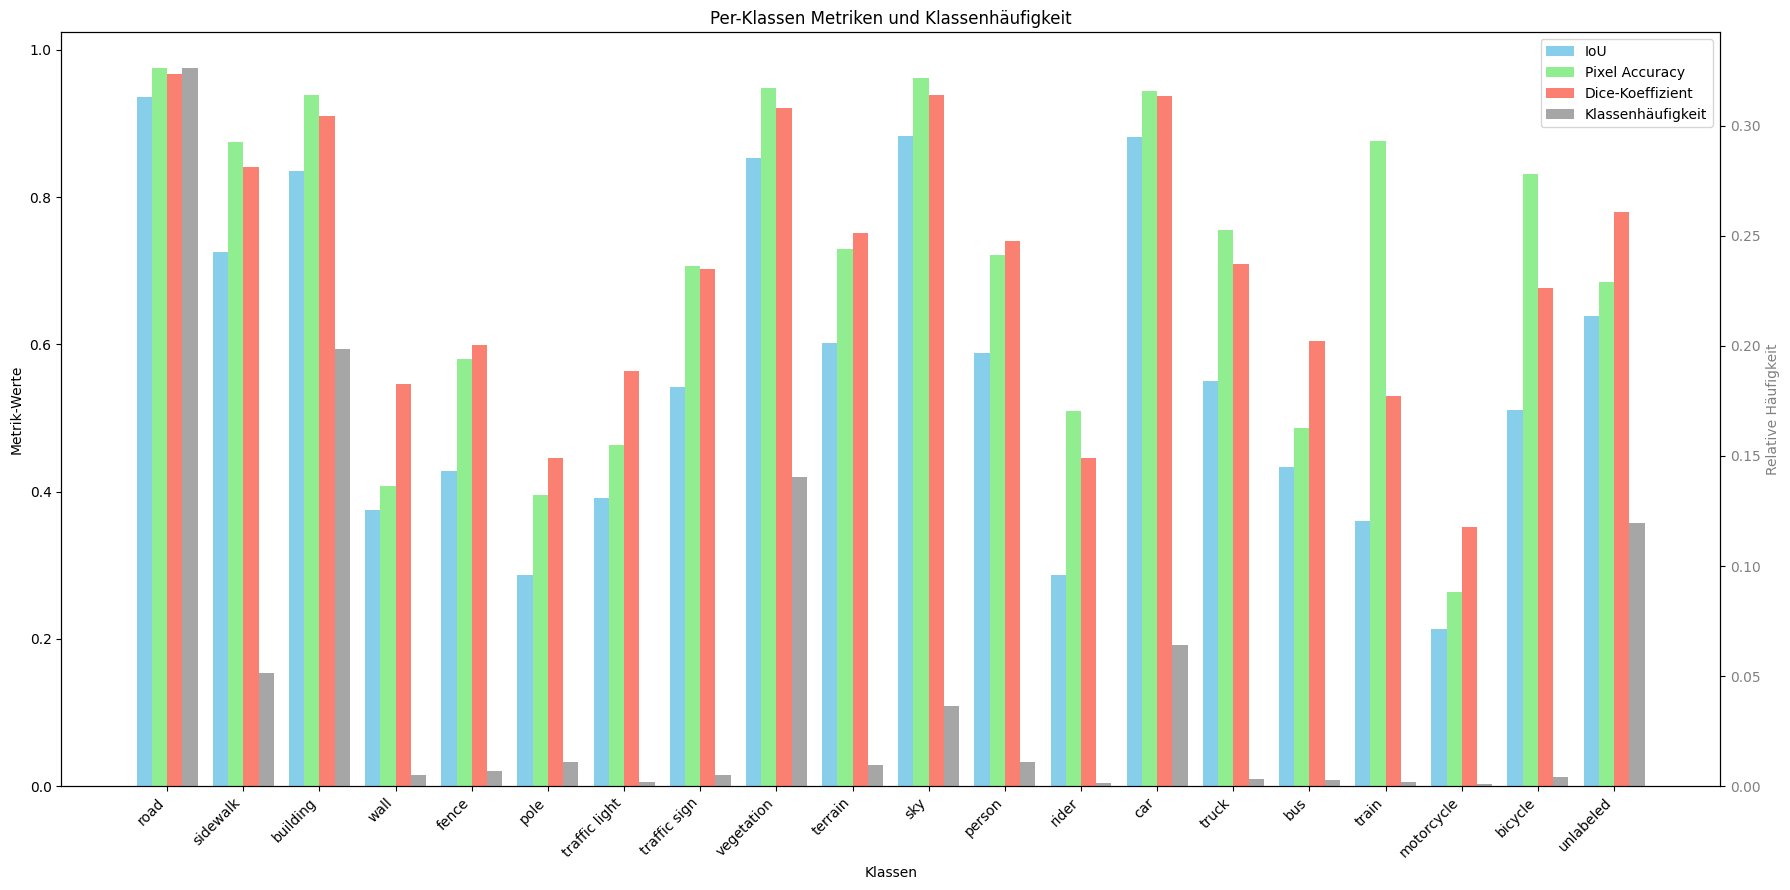


Gesamtmetriken Tabelle:
                Metric    Value
              Mean IoU 0.566026
   Mean Pixel Accuracy 0.702502
Frequency Weighted IoU 0.822699
 Mean Dice Coefficient 0.697947


In [6]:

# Anzahl der Klassen
num_classes = model.num_classes

# Klassennamen definieren
class_names = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck', 'bus',
    'train', 'motorcycle', 'bicycle', 'unlabeled'
]

# Konfusionsmatrix und Klassenhäufigkeit initialisieren
confusion_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64)
class_pixel_counts = torch.zeros(num_classes, dtype=torch.int64)

# Modell in den Evaluationsmodus setzen
model.model.eval()

# Evaluierung starten
with torch.no_grad():
    for i in tqdm(range(len(k_fold_dataset.test_dataset)), desc='Evaluating'):
        # Bild und Annotation laden
        image, annotation = k_fold_dataset.test_dataset[i]
        
        # Inferenz durchführen
        output = model.inference(image)
        predicted = output.argmax(1).squeeze(0)
        
        # Konfusionsmatrix aktualisieren
        conf_matrix = compute_confusion_matrix(predicted.cpu(), annotation.cpu(), num_classes)
        confusion_matrix += conf_matrix
        
        # Häufigkeit der Klassen in der Annotation zählen
        for cls in range(num_classes):
            class_pixel_counts[cls] += torch.sum(annotation == cls)

# Relative Häufigkeit jeder Klasse berechnen
total_pixels = class_pixel_counts.sum()
class_frequencies = class_pixel_counts.float() / total_pixels

# Metriken berechnen
miou, per_class_iou = compute_miou(confusion_matrix)
mpa, per_class_pa = compute_mean_pixel_accuracy(confusion_matrix)
fwiou = compute_fwiou(confusion_matrix)
mean_dice, per_class_dice = compute_dice_coefficient(confusion_matrix)

# Metriken und Frequenzen in NumPy-Arrays konvertieren
per_class_iou_np = per_class_iou.cpu().numpy()
per_class_pa_np = per_class_pa.cpu().numpy()
per_class_dice_np = per_class_dice.cpu().numpy()
class_frequencies_np = class_frequencies.cpu().numpy()

# Per-Klassen Metriken ausgeben
print("\nPer-Klassen Metriken:")
print("{:<20} {:>10} {:>15} {:>15} {:>15}".format("Klasse", "IoU", "Pixel Acc", "Dice-Koeff", "Häufigkeit"))
for idx in range(num_classes):
    print("{:<20} {:>10.6f} {:>15.6f} {:>15.6f} {:>15.6f}".format(
        class_names[idx],
        per_class_iou_np[idx],
        per_class_pa_np[idx],
        per_class_dice_np[idx],
        class_frequencies_np[idx]
    ))

# Zusammenführen aller Metriken in einem Diagramm
fig, ax1 = plt.subplots(figsize=(18, 9))

bar_width = 0.2
index = np.arange(num_classes)

# Balken für IoU, Pixel Accuracy, Dice-Koeffizient und Klassenhäufigkeit
bars1 = ax1.bar(index - 1.5 * bar_width, per_class_iou_np, bar_width, label='IoU', color='skyblue')
bars2 = ax1.bar(index - 0.5 * bar_width, per_class_pa_np, bar_width, label='Pixel Accuracy', color='lightgreen')
bars3 = ax1.bar(index + 0.5 * bar_width, per_class_dice_np, bar_width, label='Dice-Koeffizient', color='salmon')

# Sekundäre y-Achse für Klassenhäufigkeit
ax2 = ax1.twinx()
bars4 = ax2.bar(index + 1.5 * bar_width, class_frequencies_np, bar_width, label='Klassenhäufigkeit', color='gray', alpha=0.7)

# Achsenbeschriftungen
ax1.set_xlabel('Klassen')
ax1.set_ylabel('Metrik-Werte')
ax2.set_ylabel('Relative Häufigkeit', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# x-Achsen-Ticks
ax1.set_xticks(index)
ax1.set_xticklabels(class_names, rotation=45, ha='right')

# Legenden zusammenführen
bars = [bars1, bars2, bars3, bars4]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc='upper right')

# Titel und Layout
plt.title('Per-Klassen Metriken und Klassenhäufigkeit')
plt.tight_layout()
plt.show()

# Gesamtmetriken in einer Tabelle darstellen
metrics_data = {
    'Metric': ['Mean IoU', 'Mean Pixel Accuracy', 'Frequency Weighted IoU', 'Mean Dice Coefficient'],
    'Value': [miou, mpa, fwiou, mean_dice]
}

metrics_df = pd.DataFrame(metrics_data)
print("\nGesamtmetriken Tabelle:")
print(metrics_df.to_string(index=False))
